# Portfolio Analysis of Information technology sector

### Stocks under observation:

    - Apple (NASDAQ:AAPL) 
    - Adobe (NASDAQ:ADBE)
    - IBM (NASDAQ:IBM)
    - Salesforce.com (NASDAQ:CRM)
    - Cisco Systems (NASDAQ:CSCO)
    - Microsoft Corp. (NASDAQ:MSFT)

In [11]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [12]:
info_tech = ['AAPL', 'ADBE', 'IBM', 'CRM','CSCO', 'MSFT' ]
data = pd.DataFrame()
for i in range(len(info_tech)):
    
    df = wb.DataReader(info_tech[i], data_source='yahoo', start='2019-1-1', end = '2020-5-1' )
    df['stock'] = info_tech[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,AAPL,ADBE,CRM,CSCO,IBM,MSFT
Date,,,,,,
2019-01-02,154.794983,224.570007,135.550003,41.075611,107.361145,99.099190
2019-01-03,139.376251,215.699997,130.399994,39.581779,105.217842,95.453529
2019-01-04,145.326126,226.190002,137.960007,41.364738,109.327393,99.893005
2019-01-07,145.002686,229.259995,142.220001,41.644226,110.100861,100.020401
2019-01-08,147.766861,232.679993,145.720001,41.981548,111.666405,100.745613


Text(0, 0.5, 'price in $')

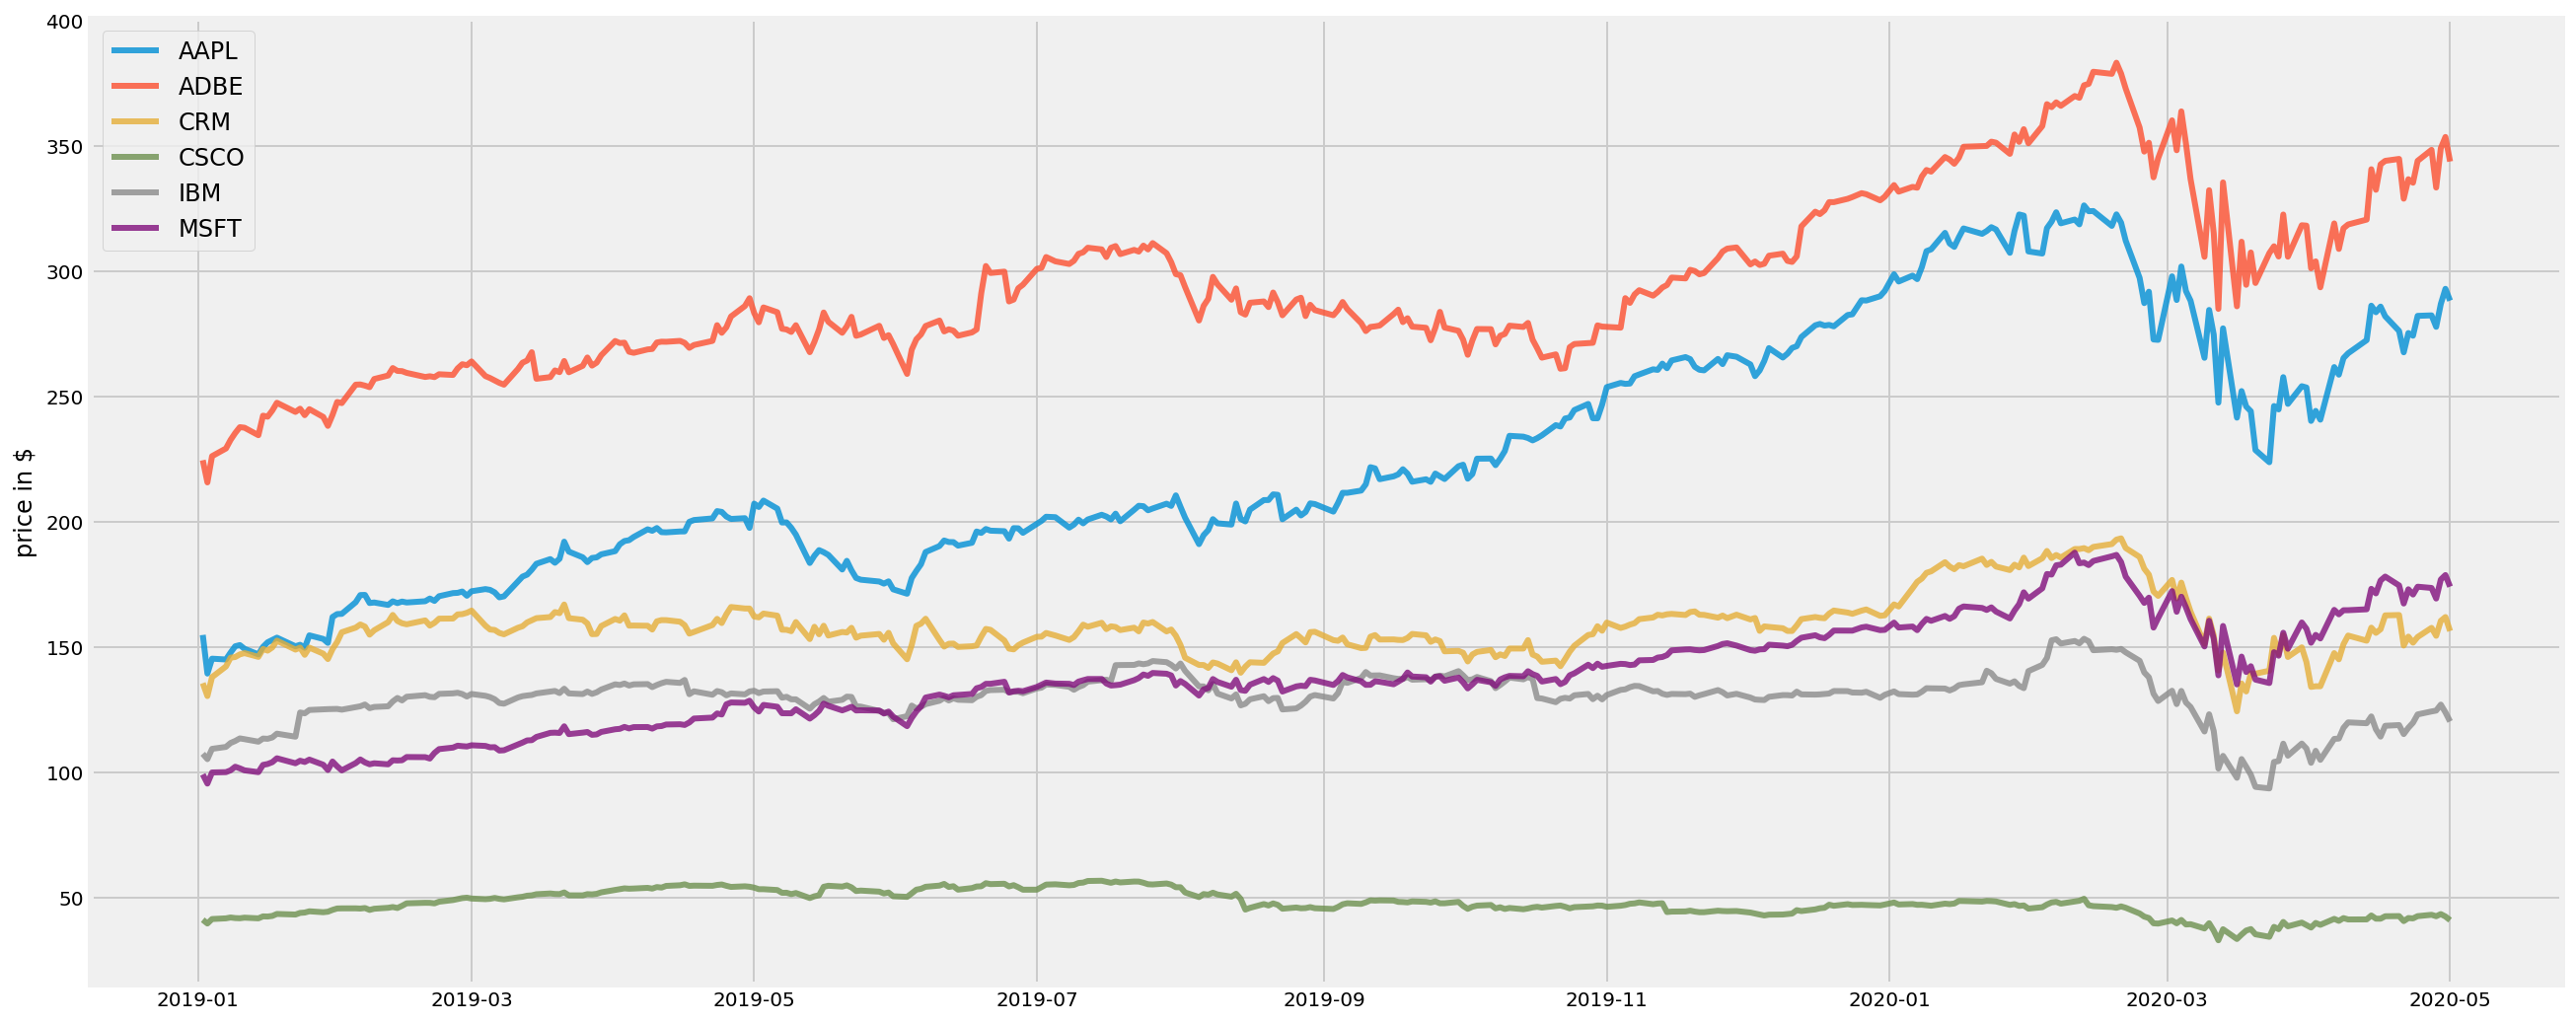

In [13]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

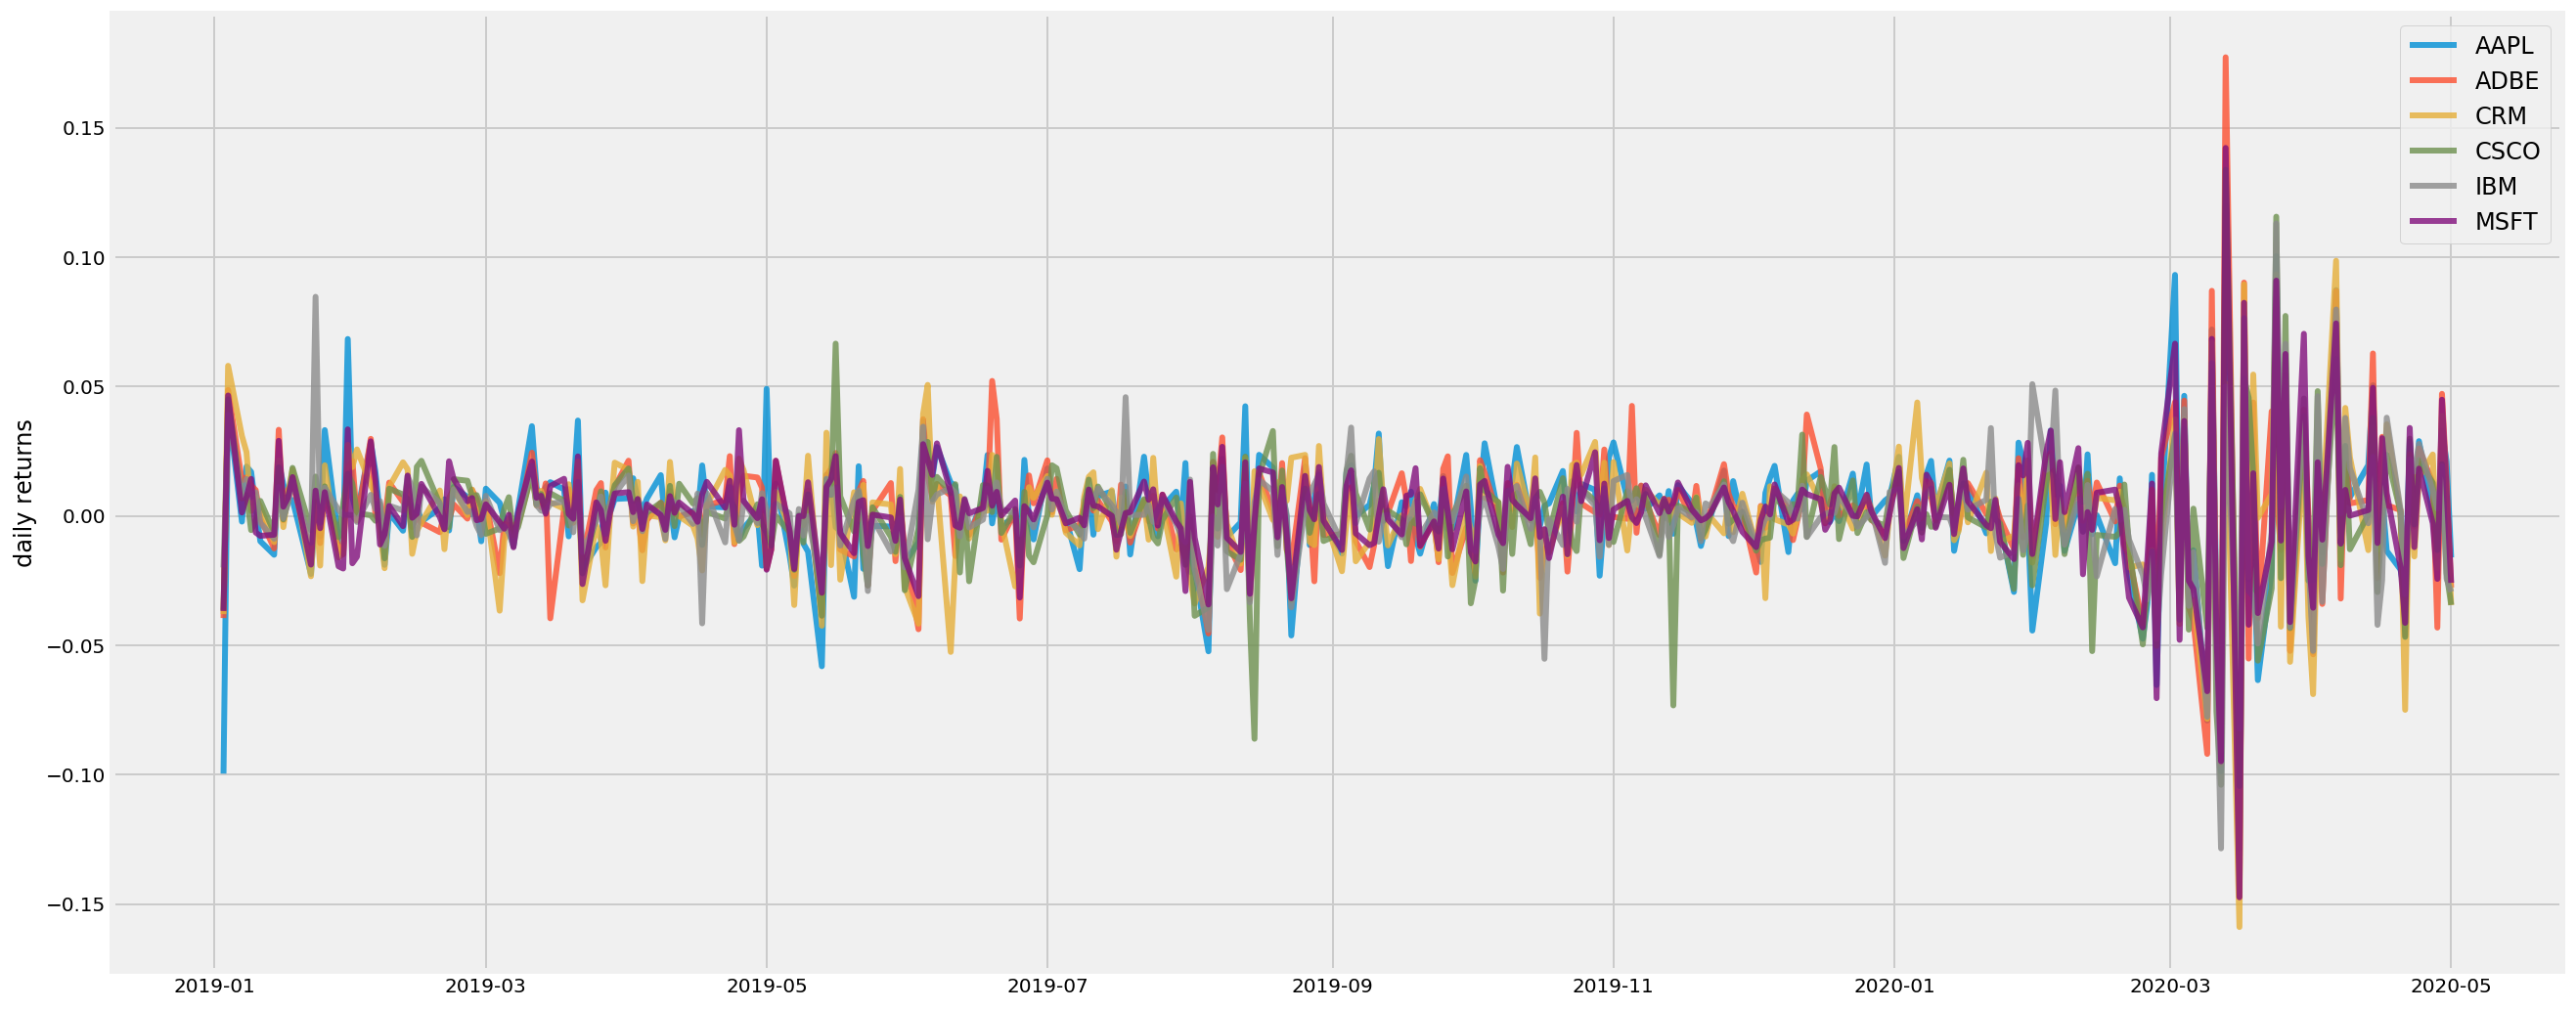

In [14]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

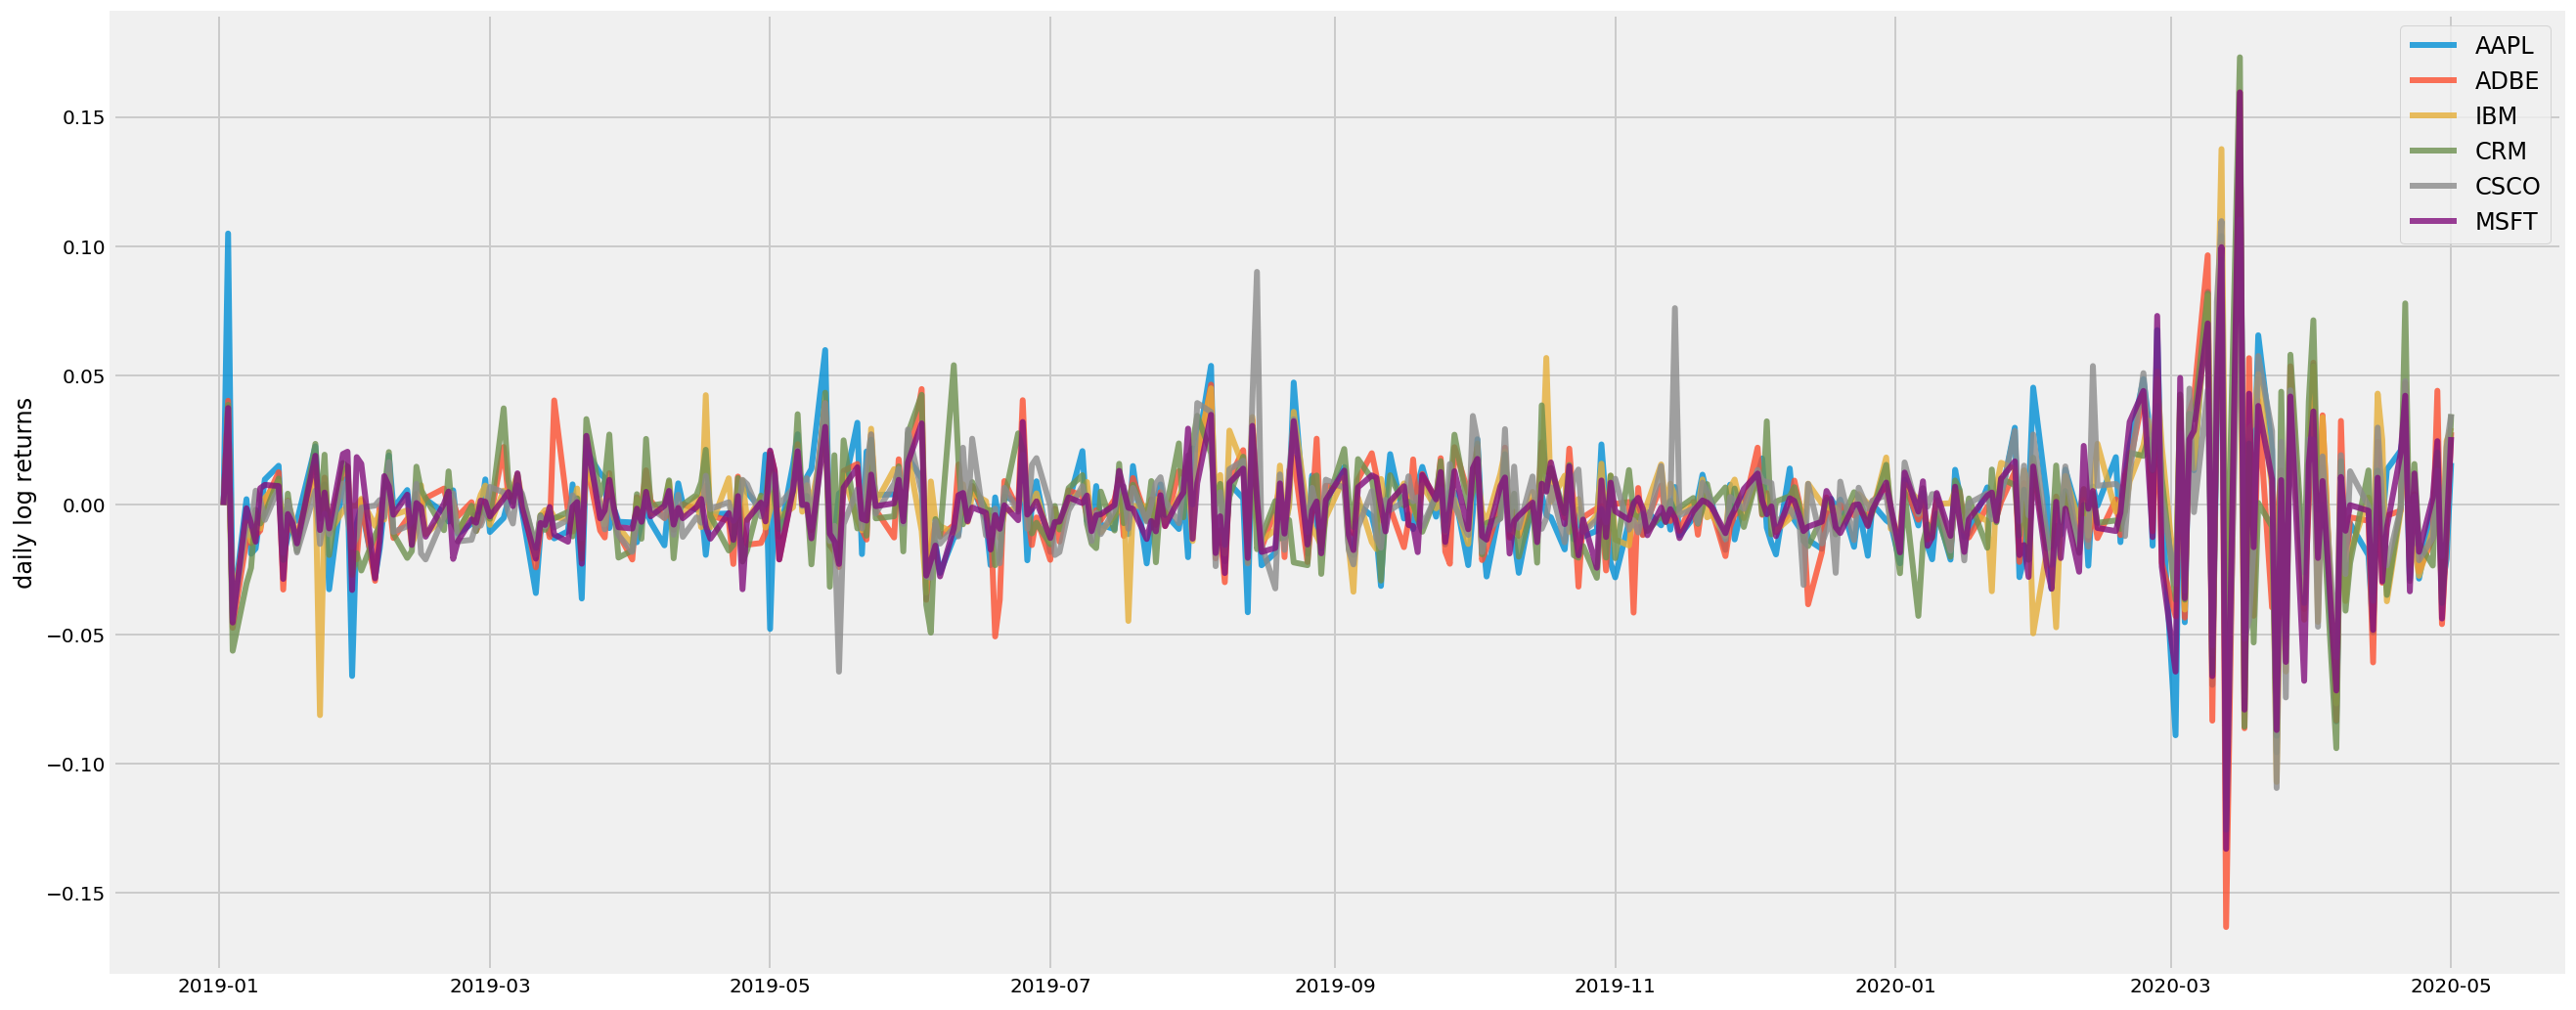

In [15]:
log = pd.DataFrame(columns = info_tech, index = table.index)

for i in range(len(info_tech)):
    log_list = []
    for j in range(len(table[info_tech[i]])):
        if(j+1<len(table[info_tech[i]])):
            log_returns =  np.log(table[info_tech[i]][j]) - np.log(table[info_tech[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[info_tech[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

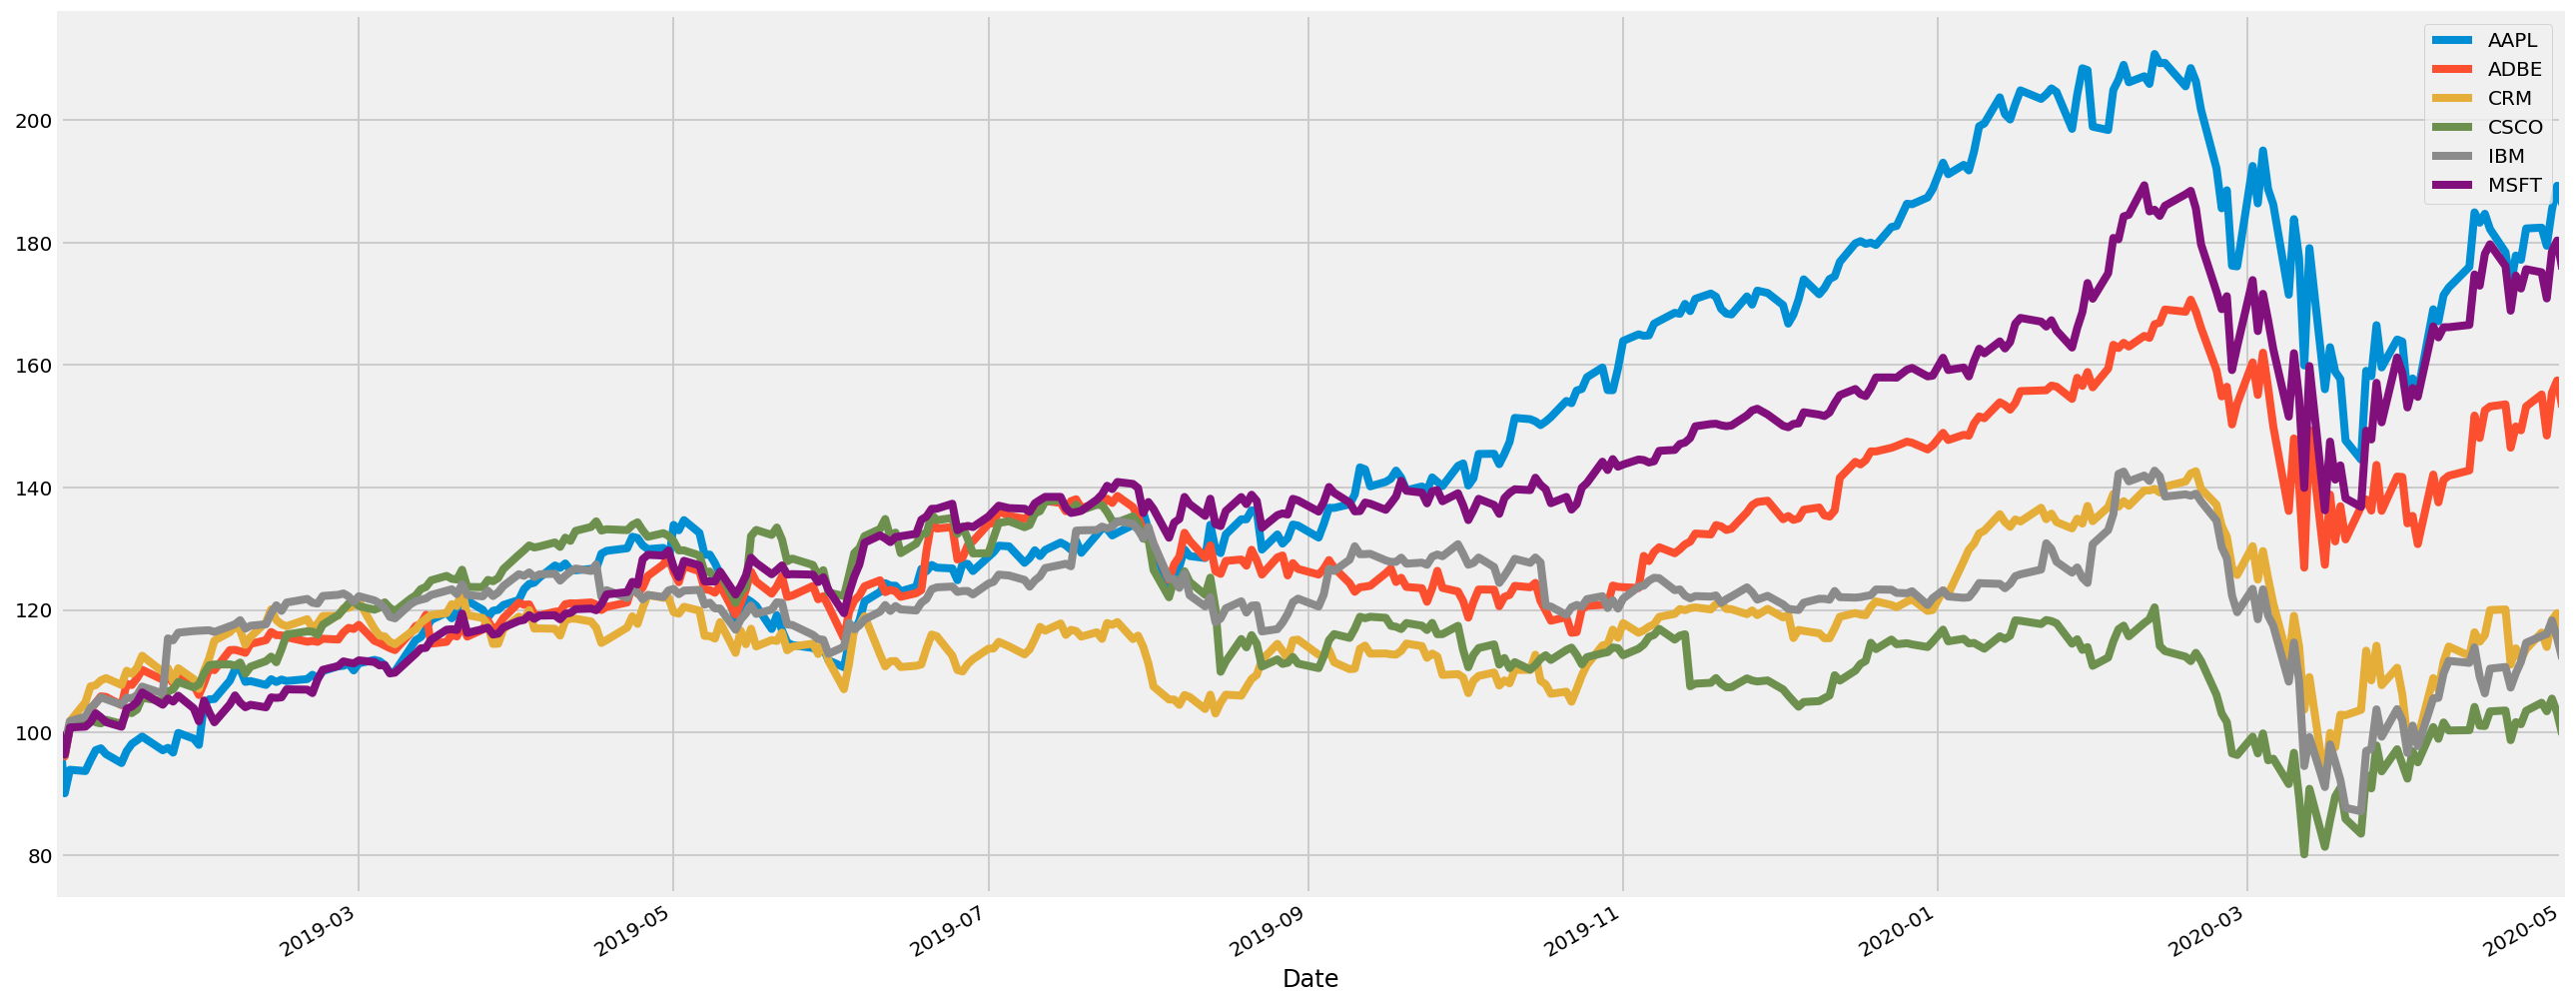

In [16]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [17]:
log.mean()*252

AAPL   -0.466398
ADBE   -0.319492
IBM    -0.085076
CRM    -0.107163
CSCO    0.002847
MSFT   -0.422568
dtype: float64

In [18]:
log.std()*252**0.5

AAPL    0.384382
ADBE    0.392545
IBM     0.341230
CRM     0.383239
CSCO    0.367145
MSFT    0.362906
dtype: float64

“portfolio_annualised_performance” function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. “random_portfolios” function will generate portfolios with random weights assigned to each stock, and by giving num_portfolios argument, you can decide how many random portfolios you want to generate.

risk free rate = 0.02

In [19]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return(results, weights_record)

mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.0073

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.48
Annualised Volatility: 0.35


             AAPL  ADBE   CRM  CSCO   IBM   MSFT
allocation  46.11  5.03  1.16  3.25  3.21  41.24
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.32


             AAPL  ADBE    CRM   CSCO    IBM  MSFT
allocation  10.16  4.29  19.11  15.59  44.78  6.06


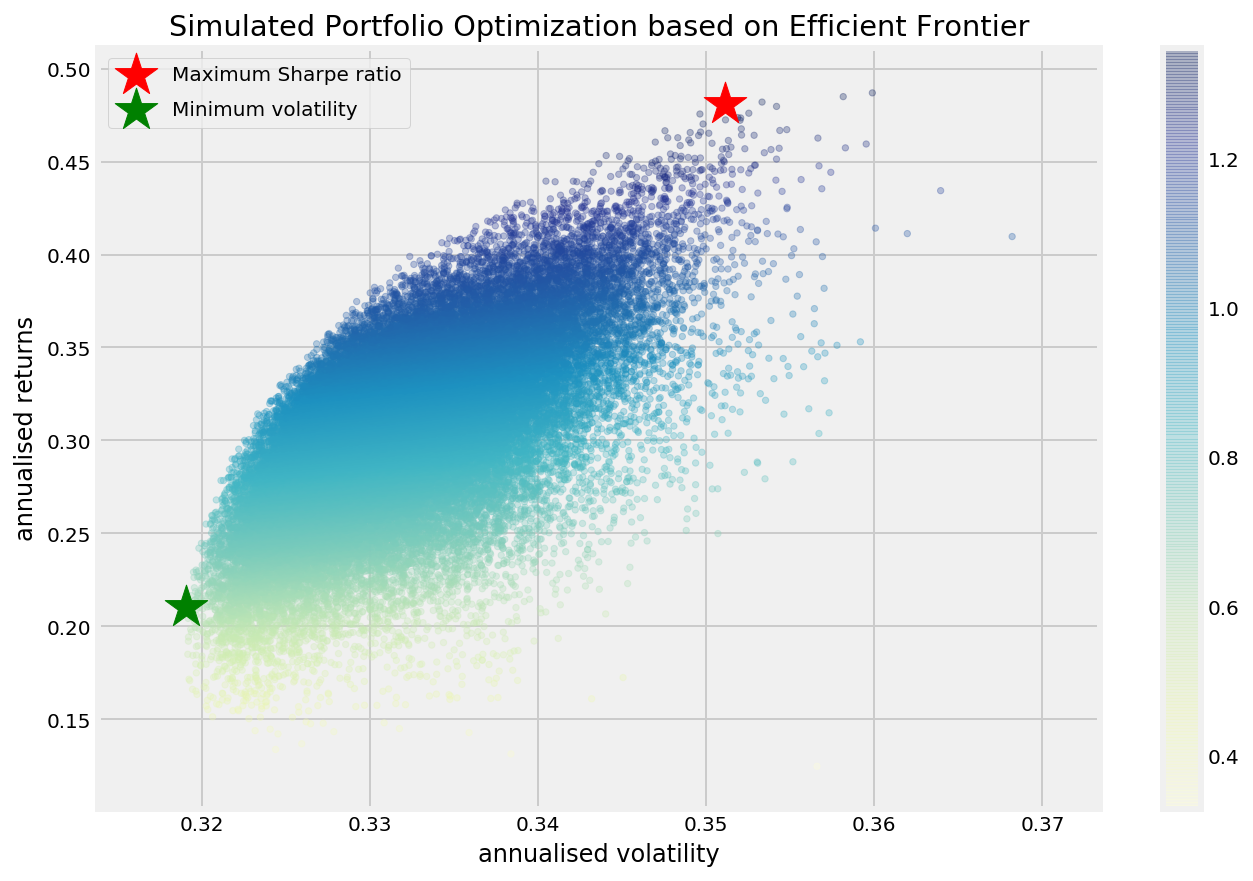

In [20]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)